In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

In [2]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

## 1. INITIAL REVIEW OF THE DATA

In [3]:
series = pd.read_csv('zillow-carlifornia.csv', parse_dates=True,squeeze=True, index_col=0)
#Cleaning column names:
series.columns=['MedianSoldPrice','MedianMortageRate','UnemploymentRate','MedianRentalPrice']

In [4]:
series.head(5)

MedianSoldPrice  MedianMortageRate  UnemploymentRate  \
Date                                                               
2004-01-31        326752.55               5.02               7.9   
2004-02-29        329501.50               4.94               7.8   
2004-03-31        340125.45               4.74               7.8   
2004-04-30        355329.50               5.16               7.5   
2004-05-31        367818.15               5.64               7.3   

            MedianRentalPrice  
Date                           
2004-01-31                NaN  
2004-02-29                NaN  
2004-03-31                NaN  
2004-04-30                NaN  
2004-05-31                NaN

/Users/jingwenyu/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


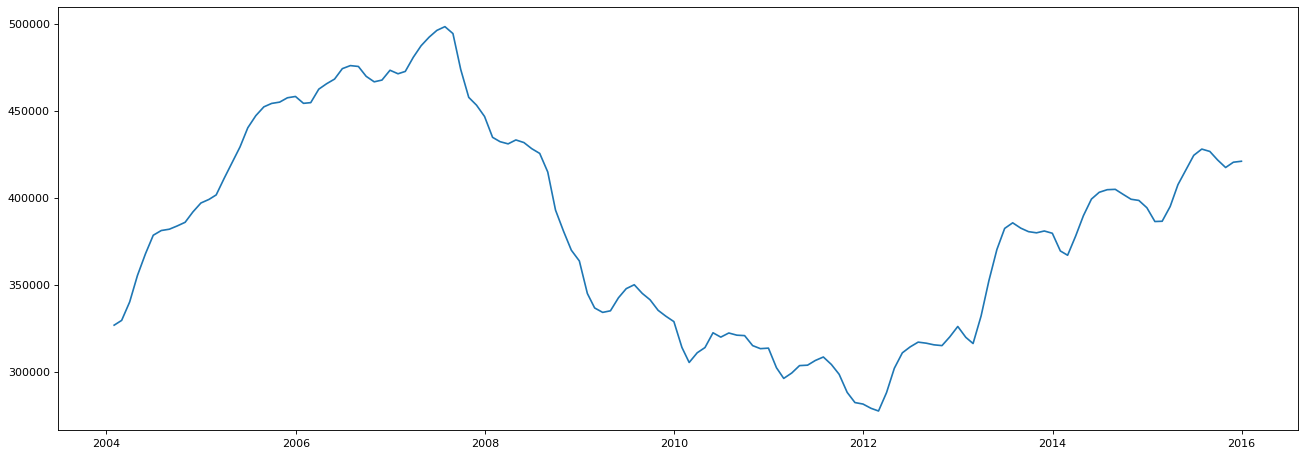

In [5]:
# MedianSoldprice : TARGET
plt.figure(figsize=(20,7), dpi=80)
plt.plot(series['MedianSoldPrice'])
plt.show()

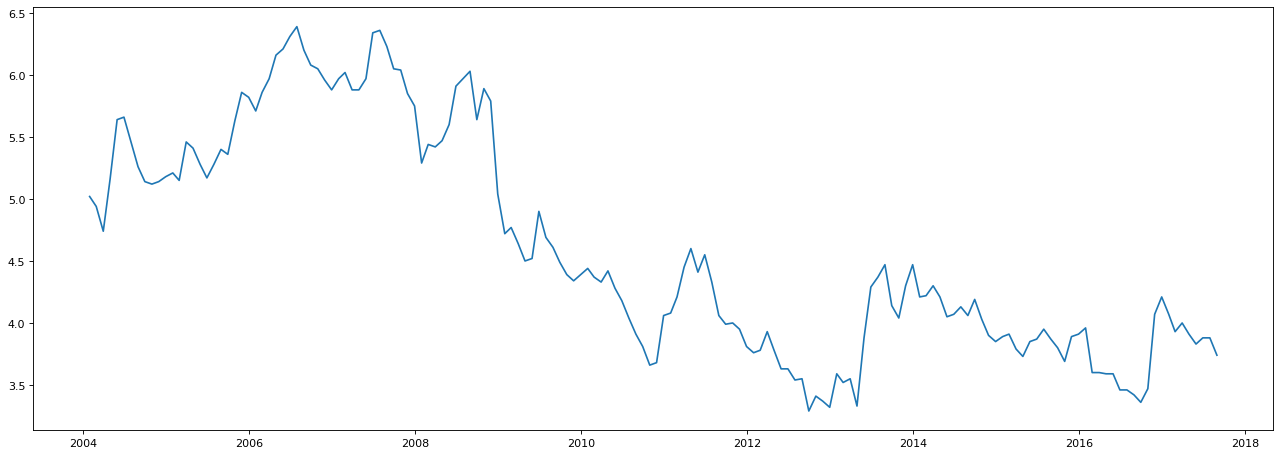

In [6]:
# MedianMortagerate 
plt.figure(figsize=(20,7), dpi=80)
plt.plot(series['MedianMortageRate'])
plt.show()

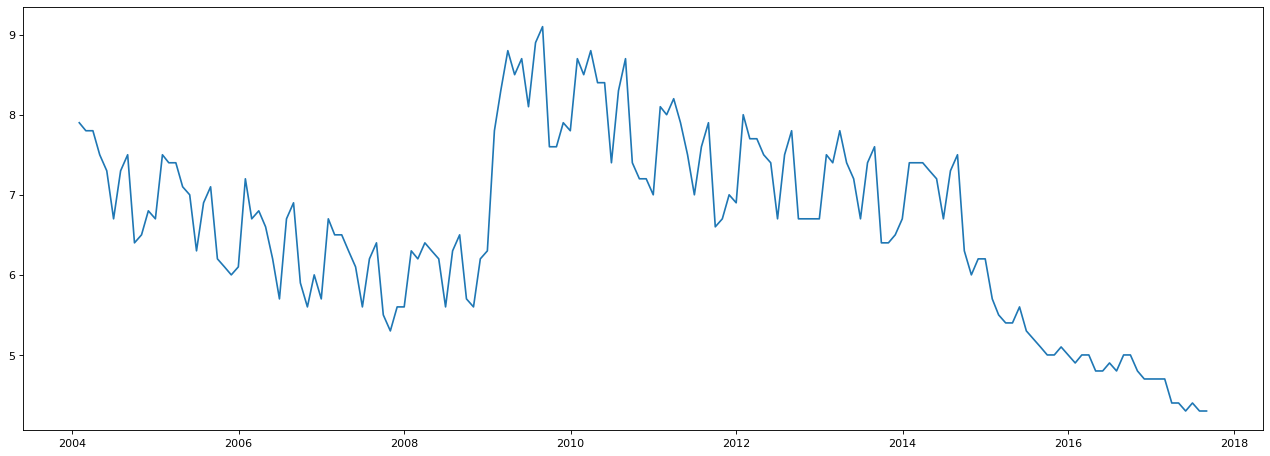

In [7]:
# Unemployment rate
plt.figure(figsize=(20,7), dpi=80)
plt.plot(series['UnemploymentRate'])
plt.show()

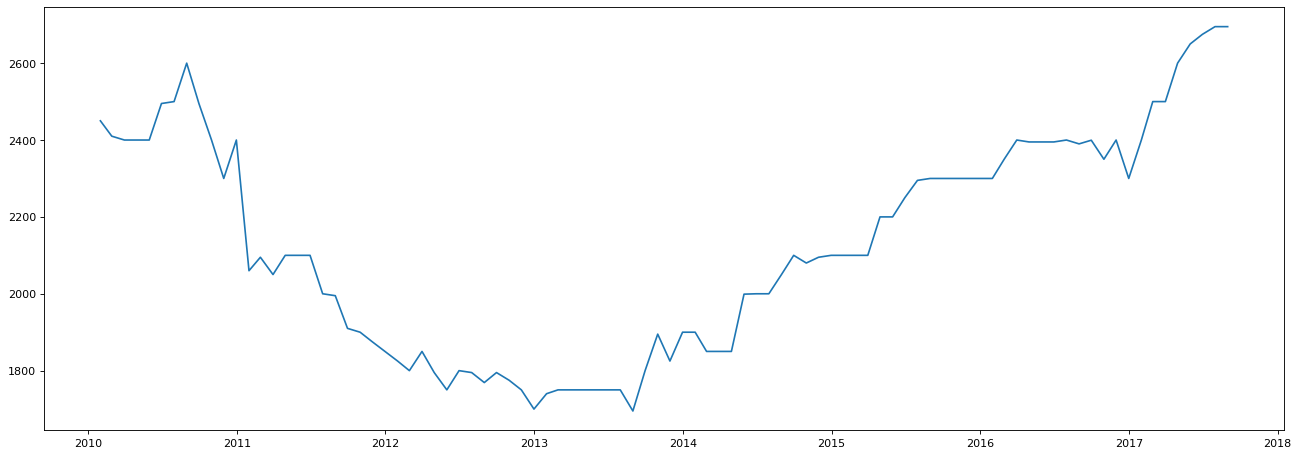

In [8]:
# Rental price
plt.figure(figsize=(20,7), dpi=80)
plt.plot(series['MedianRentalPrice'])
plt.show()

In [9]:
#Checking null values in each column
series.isna().sum()

MedianSoldPrice      20
MedianMortageRate     0
UnemploymentRate      0
MedianRentalPrice    72
dtype: int64

MedianSoldPrice  MedianMortageRate  UnemploymentRate  \
MedianSoldPrice           1.000000           0.051154         -0.709700   
MedianMortageRate         0.051154           1.000000          0.295279   
UnemploymentRate         -0.709700           0.295279          1.000000   
MedianRentalPrice         0.125483           0.269039         -0.033633   

                   MedianRentalPrice  
MedianSoldPrice             0.125483  
MedianMortageRate           0.269039  
UnemploymentRate           -0.033633  
MedianRentalPrice           1.000000

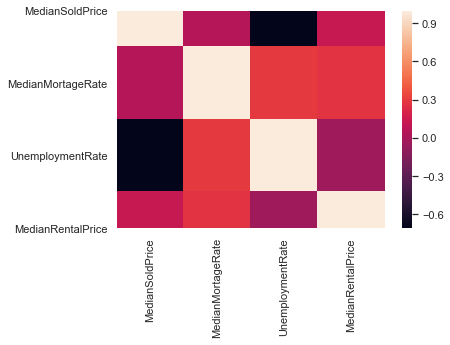

In [10]:
# Correlation matrix for recent years: 2010- 2016
# We see a strong negative relationship between UnemploymentRate - MedianSoldPrice...
import seaborn as sns; sns.set()

series_interval=series.loc[(series.index >= '2010-01-01') & (series.index <='2015-12-31') ]
sns.heatmap(series_interval.corr())
series_interval.corr()

## 2. MODELLING

## 2.1 Modelling with Univariate SARIMA

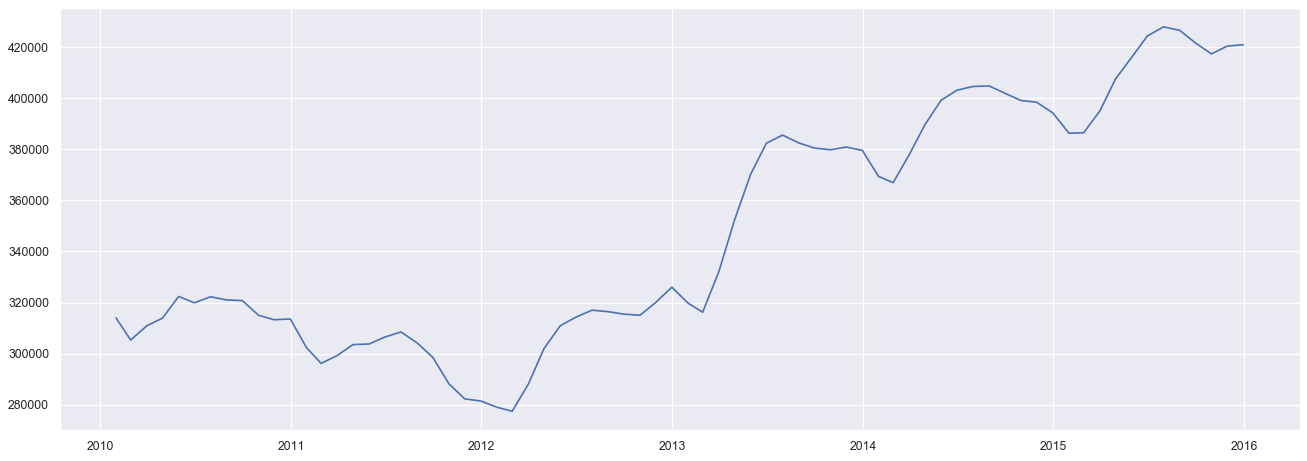

In [11]:
# We consider RECENT years for the modelling: 2010 - 2016
series_recent=series.loc[(series.index >= '2010-01-01') & (series.index <='2015-12-31') ]
series_mediansoldprice=series_recent.MedianSoldPrice

plt.figure(figsize=(20,7), dpi=80)
plt.plot(series_mediansoldprice)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                 -1.446016
p-value                         0.560028
#Lags Used                     12.000000
Number of Observations Used    58.000000
Critical Value (1%)            -3.548494
Critical Value (5%)            -2.912837
Critical Value (10%)           -2.594129
dtype: float64


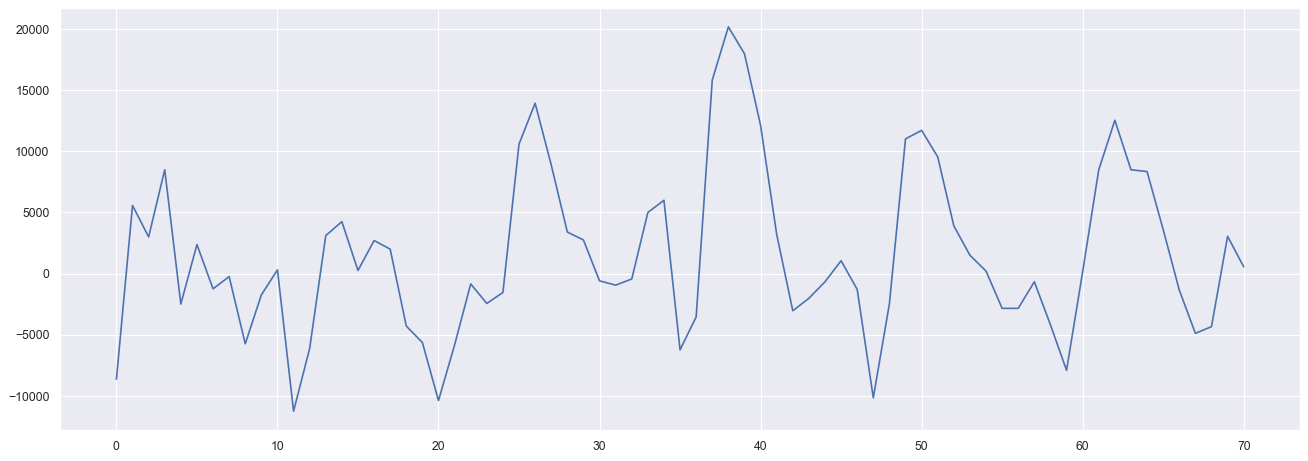

In [12]:
#Getting rid of TREND d=1
#ADF>0.05 (not stationary yet)
d1 = list()
for i in range(1, len(series_mediansoldprice)):
 value = series_mediansoldprice[i] - series_mediansoldprice[i - 1]
 d1.append(value)

adf_test(d1)
plt.figure(figsize=(20,7), dpi=80)
plt.plot(d1) 
pyplot.show()

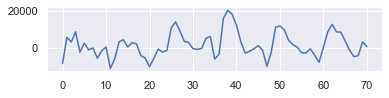

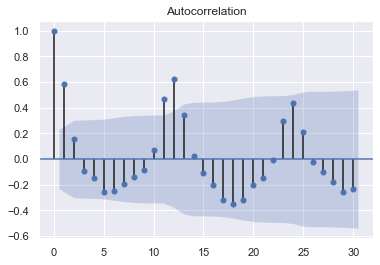

/Users/jingwenyu/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


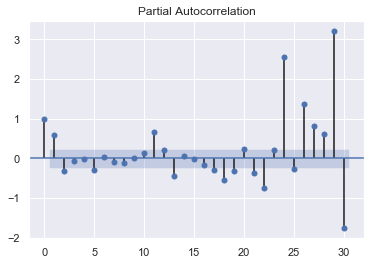

In [13]:
#Analizing trend and seasonality
# There is trend
# possible seasonality m=12
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.subplot(3,1,1)
plt.plot(d1) 
plt.show()
plot_acf(d1,lags=30) 
plt.show()
plot_pacf(d1,lags=30) 
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                 -3.246561
p-value                         0.017443
#Lags Used                     11.000000
Number of Observations Used    58.000000
Critical Value (1%)            -3.548494
Critical Value (5%)            -2.912837
Critical Value (10%)           -2.594129
dtype: float64


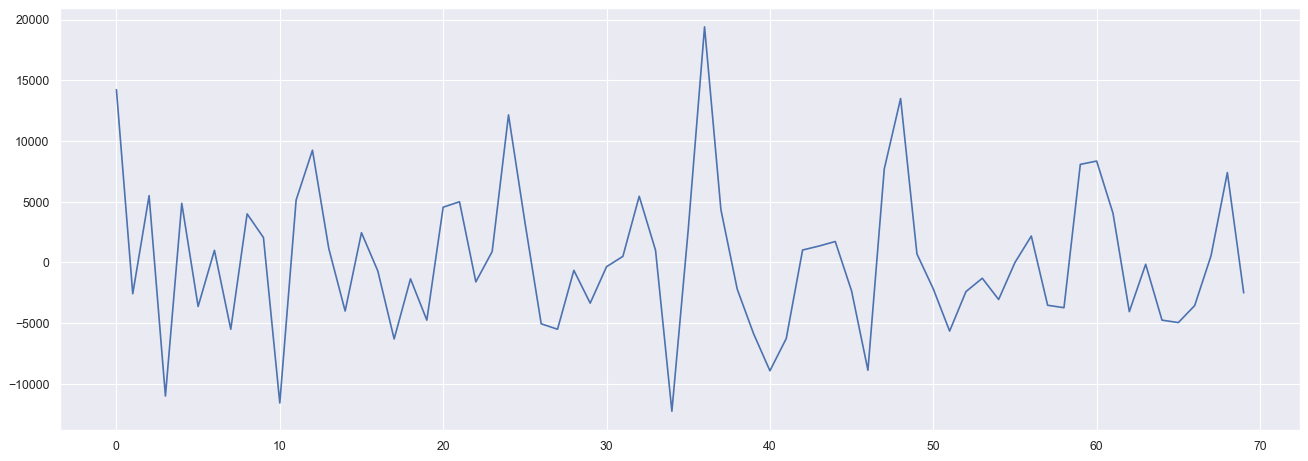

In [14]:
#Getting rid of TREND d=2 :
# ADF < 0.05 (stationary)
d2 = list()
for i in range(1, len(d1)):
 value = d1[i] - d1[i - 1]
 d2.append(value)

adf_test(d2)
plt.figure(figsize=(20,7), dpi=80)
plt.plot(d2) 
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                 -2.311463
p-value                         0.168298
#Lags Used                     11.000000
Number of Observations Used    57.000000
Critical Value (1%)            -3.550670
Critical Value (5%)            -2.913766
Critical Value (10%)           -2.594624
dtype: float64


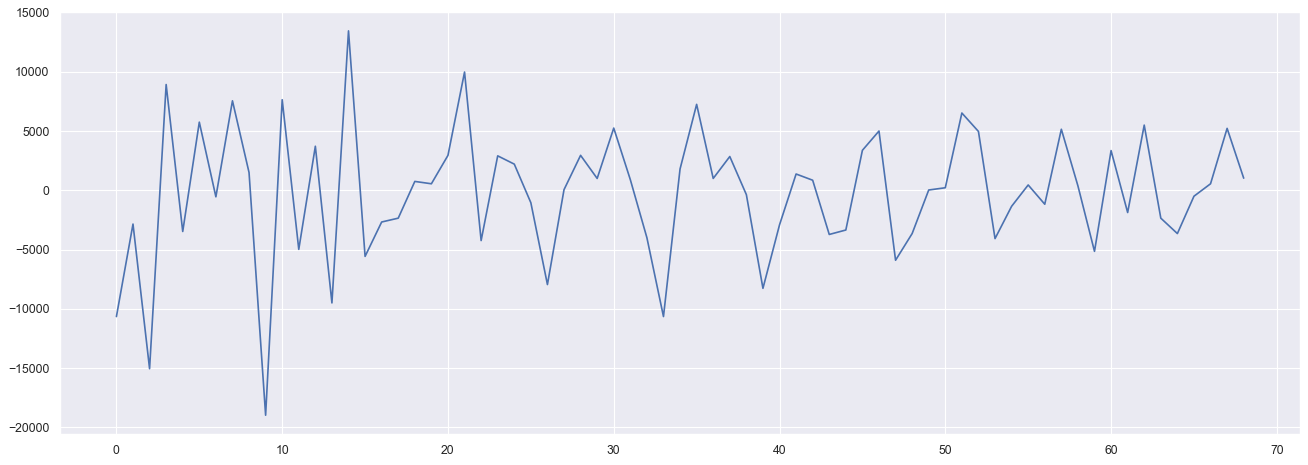

In [15]:
# Smoothing seasonality m=12
d3 = list()
for i in range(1, len(d2)):
 value = d2[i] - d2[i - 12]
 d3.append(value)

adf_test(d3)
plt.figure(figsize=(20,7), dpi=80)
plt.plot(d3) 
plt.show()

In [16]:
train_size = int(len(series_mediansoldprice) * 0.80)
train, test = series_mediansoldprice[:train_size], series_mediansoldprice[train_size:]
train.tail()

Date
2014-05-31    399250.0
2014-06-30    403150.0
2014-07-31    404650.0
2014-08-31    404850.0
2014-09-30    402000.0
Name: MedianSoldPrice, dtype: float64

In [17]:
model = pm.auto_arima(train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12,              # frequency of series
                      d=2,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 1, 1, 12); AIC=849.803, BIC=858.609, Fit time=0.345 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 1, 0, 12); AIC=858.047, BIC=861.569, Fit time=0.007 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(1, 1, 0, 12); AIC=855.659, BIC=862.704, Fit time=0.066 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 1, 1, 12); AIC=855.662, BIC=862.707, Fit time=0.060 seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(1, 1, 1, 12); AIC=857.980, BIC=868.547, Fit time=0.278 seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 1, 0, 12); AIC=854.817, BIC=861.861, Fit time=0.116 seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 1, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(1, 1, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 2, 1) seasonal_order=(0, 1, 1, 12); AIC=850.799, BIC=861.366, Fit time=0.541 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(0, 1, 1, 12); AIC=855.8

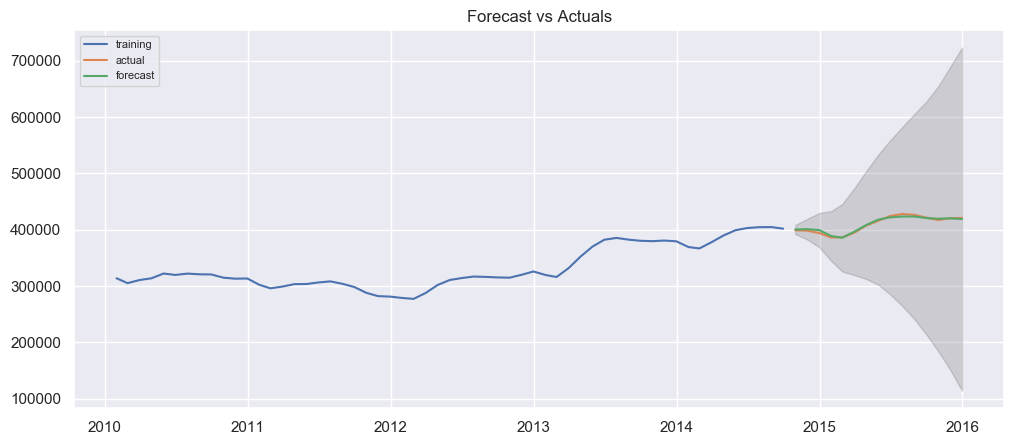

In [18]:
# Using only SARIMA
fitted = model.fit(train)
fc, conf = fitted.predict(len(test),return_conf_int=True,alpha=0.05)
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [19]:
#Using SARIMA : 2500 dollars of error...
rmse = sqrt(mean_squared_error(test.values, fc_series.values))
rmse

2511.5847192850847

## 2.2 Modelling with SARIMAX v1 (with only unemployment rate)

In [20]:
#Function of trend differencing and seasonality differencing
def trend_diff(X):
    d = list()
    for i in range(1, len(X)):
        value = X[i] - X[i - 1]
        d.append(value)
    adf_test(d)
    plt.subplot(2,1,1)
    plt.plot(d) 
    plt.show()
    plot_acf(d,lags=30) 
    plt.show()
    return d

def ssn_diff(X, m):
    d = list()
    for i in range(m, len(X)):
        value = X[i] - X[i - m]
        d.append(value)
    adf_test(d)
    plt.subplot(2,1,1)
    plt.plot(d) 
    plt.show()
    plot_acf(d,lags=30) 
    plt.show()
    return d

In [21]:
all_price = series[~series.MedianSoldPrice.isna()]['MedianSoldPrice']

Results of Dickey-Fuller Test:
Test Statistic                  -1.687305
p-value                          0.437665
#Lags Used                      12.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


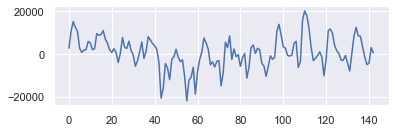

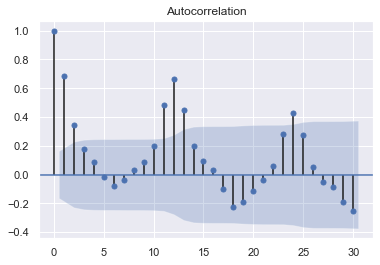

In [22]:
all_price_d1 = trend_diff(all_price)

Results of Dickey-Fuller Test:
Test Statistic                  -4.918846
p-value                          0.000032
#Lags Used                      11.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


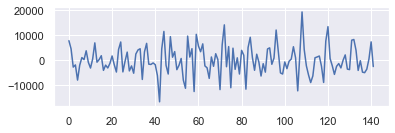

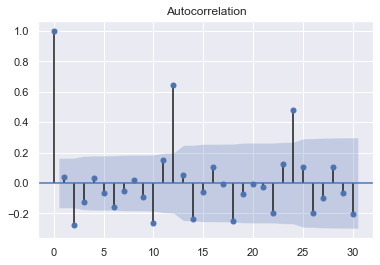

In [23]:
all_price_d2 = trend_diff(all_price_d1)

Results of Dickey-Fuller Test:
Test Statistic                  -5.149454
p-value                          0.000011
#Lags Used                      13.000000
Number of Observations Used    116.000000
Critical Value (1%)             -3.488022
Critical Value (5%)             -2.886797
Critical Value (10%)            -2.580241
dtype: float64


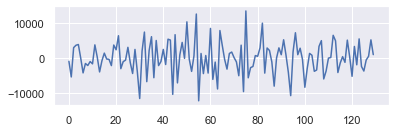

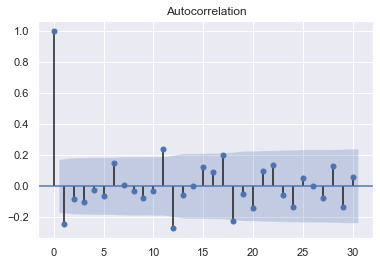

In [24]:
all_price_d3 = ssn_diff(all_price_d2, 12)

In [25]:
train_size_allprice = int(len(all_price) * 0.90)
train_allprice = all_price[:train_size_allprice]
test_allprice = all_price[train_size_allprice:]

In [26]:
model_allprice = pm.auto_arima(train_allprice, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12,              # frequency of series
                      d=2,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model_allprice.summary())

Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 1, 1, 12); AIC=2271.014, BIC=2284.739, Fit time=0.534 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 1, 0, 12); AIC=2281.524, BIC=2287.014, Fit time=0.014 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(1, 1, 0, 12); AIC=2285.121, BIC=2296.101, Fit time=0.231 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 1, 1, 12); AIC=2285.271, BIC=2296.250, Fit time=0.207 seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(1, 1, 1, 12); AIC=2272.973, BIC=2289.443, Fit time=0.857 seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 1, 0, 12); AIC=2269.067, BIC=2280.047, Fit time=0.129 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 1, 0, 12); AIC=2283.388, BIC=2291.623, Fit time=0.042 seconds
Fit ARIMA: order=(2, 2, 1) seasonal_order=(0, 1, 0, 12); AIC=2271.067, BIC=2284.792, Fit time=0.265 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(0, 1, 0, 12); AIC=2283.236, BIC=2291.470, Fit time=0.031 seconds
Fit ARIMA: order=(1, 2, 2) s

In [27]:
# Modelling with only UnemploymentRate, all time frame
series_x3=series[['UnemploymentRate']]
exog_train3=series_x3[:train_size_allprice]
exog_test3=series_x3[train_size_allprice:-20]

In [28]:
#SARIMAX(1, 2, 1)x(0, 1, 0, 12)
modelx3 = SARIMAX(train_allprice, order=(1,2,1), seasonal_order=(0,1,0,12),exog=exog_train3)
fitx3=modelx3.fit()
print(fitx3.summary())

                                 Statespace Model Results                                 
Dep. Variable:                    MedianSoldPrice   No. Observations:                  129
Model:             SARIMAX(1, 2, 1)x(0, 1, 0, 12)   Log Likelihood               -1132.170
Date:                            Mon, 09 Dec 2019   AIC                           2272.340
Time:                                    22:06:21   BIC                           2283.319
Sample:                                01-31-2004   HQIC                          2276.796
                                     - 09-30-2014                                         
Covariance Type:                              opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
UnemploymentRate   370.2004   1035.629      0.357      0.721   -1659.595    2399.996
ar.L1            

/Users/jingwenyu/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


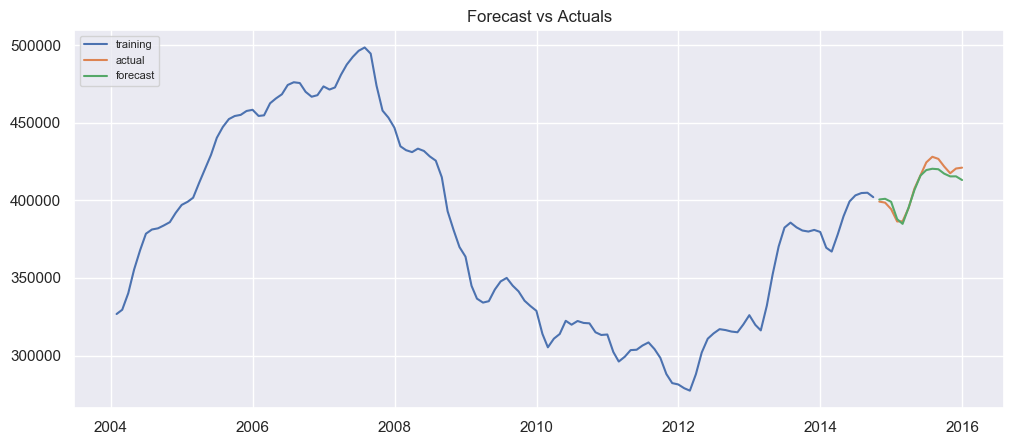

In [29]:
fc = fitx3.predict(start=129, end=143, exog=exog_test3)
fc_series = pd.Series(fc)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_allprice, label='training')
plt.plot(test_allprice, label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [30]:
#RMSE is higher than with SARIMA ONLY!!!
rmse = sqrt(mean_squared_error(test_allprice.values, fc_series.values))
rmse

4312.086182138143

## 2.3 Modelling with SARIMAX v2 (with imputed values)

### 2.3.1 Imputing Missing Median Rental Price during 2004-2009

In [31]:
# choosing the existing median rental price and reverse it
series_recent_rental = series.loc[(series.index >= '2010-01-01')]['MedianRentalPrice']
series_recent_rental = series_recent_rental.iloc[::-1]
series_recent_rental

Date
2017-08-31    2695.0
2017-07-31    2695.0
2017-06-30    2675.0
2017-05-31    2650.0
2017-04-30    2600.0
               ...  
2010-05-31    2400.0
2010-04-30    2400.0
2010-03-31    2400.0
2010-02-28    2410.0
2010-01-31    2450.0
Name: MedianRentalPrice, Length: 92, dtype: float64

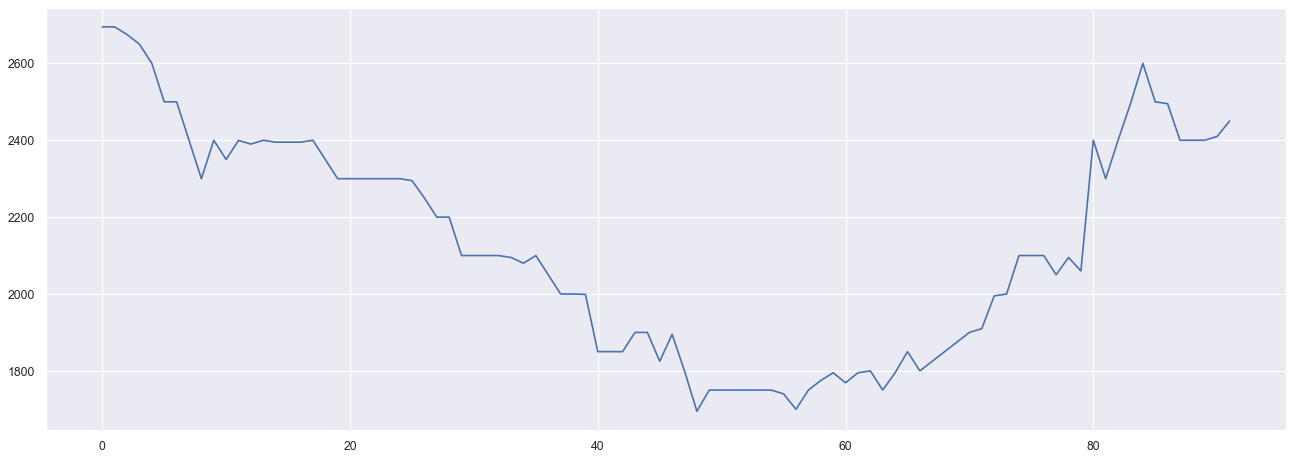

In [32]:
plt.figure(figsize=(20,7), dpi=80)
plt.plot(list(series_recent_rental))
pyplot.show()

Results of Dickey-Fuller Test:
Test Statistic                -5.850270e+00
p-value                        3.603010e-07
#Lags Used                     1.000000e+00
Number of Observations Used    8.900000e+01
Critical Value (1%)           -3.506057e+00
Critical Value (5%)           -2.894607e+00
Critical Value (10%)          -2.584410e+00
dtype: float64


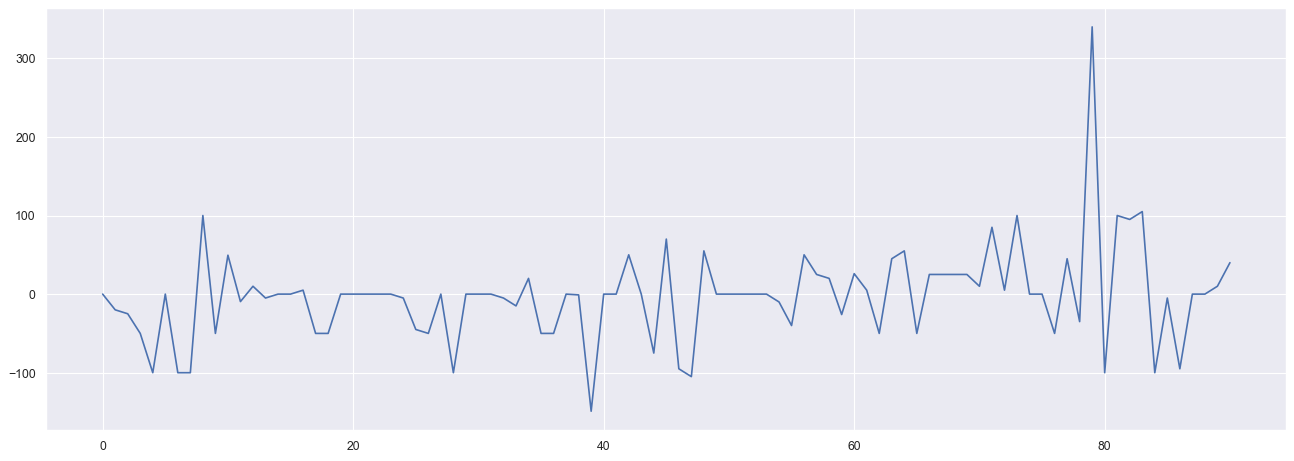

In [33]:
d1_rental = np.diff(series_recent_rental)

adf_test(d1_rental)
plt.figure(figsize=(20,7), dpi=80)
plt.plot(d1_rental) 
pyplot.show()

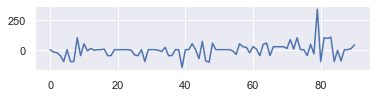

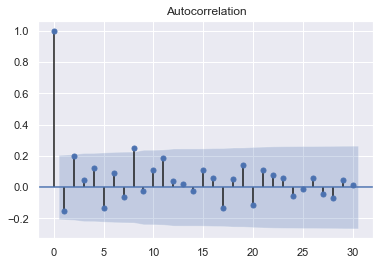

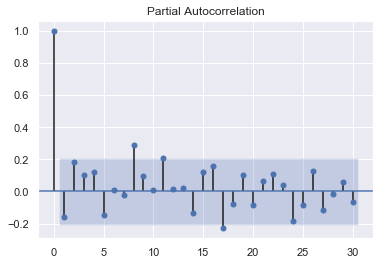

In [34]:
# Analyzing seasonality according to acf plot and pacf plot
plt.subplot(3,1,1)
plt.plot(d1_rental) 
plt.show()
plot_acf(d1_rental,lags=30) 
plt.show()
plot_pacf(d1_rental,lags=30) 
plt.show()

In [35]:
# train-test split
train_size_rental = int(len(series_recent_rental) * 0.80)
train_rental, test_rental = series_recent_rental[:train_size_rental], series_recent_rental[train_size_rental:]
train_rental.tail()

Date
2011-12-31    1850.0
2011-11-30    1875.0
2011-10-31    1900.0
2011-09-30    1910.0
2011-08-31    1995.0
Name: MedianRentalPrice, dtype: float64

In [36]:
modelr = pm.auto_arima(train_rental, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(modelr.summary())

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=659.035, BIC=669.506, Fit time=0.374 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=671.363, BIC=675.551, Fit time=0.008 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=664.442, BIC=672.819, Fit time=0.169 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=657.037, BIC=665.415, Fit time=0.357 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=658.308, BIC=668.780, Fit time=0.516 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=667.917, BIC=674.200, Fit time=0.055 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=657.773, BIC=664.056, Fit time=0.144 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 1, 1, 12); AIC=659.0

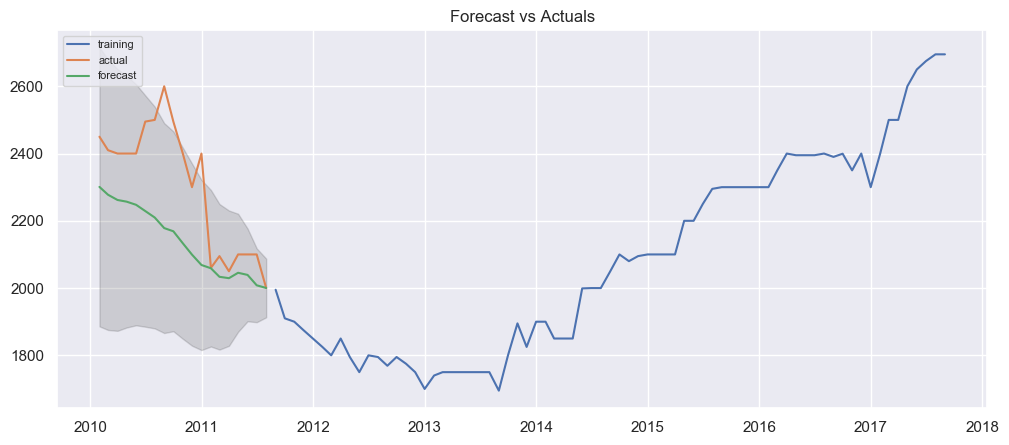

In [37]:
fittedr = modelr.fit(train_rental)
fcr, confr = fittedr.predict(len(test_rental),return_conf_int=True,alpha=0.05)
fc_seriesr = pd.Series(fcr, index=test_rental.index)
lower_seriesr = pd.Series(confr[:, 0], index=test_rental.index)
upper_seriesr = pd.Series(confr[:, 1], index=test_rental.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_rental, label='training')
plt.plot(test_rental, label='actual')
plt.plot(fc_seriesr, label='forecast')
plt.fill_between(lower_seriesr.index, lower_seriesr, upper_seriesr, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [38]:
# imputing missing value
fcr2 = fittedr.predict(len(test_rental)+72)
# fc_seriesr = pd.Series(fcr, index=test_rental.index)
fc_seriesr2 = pd.Series(fcr2)
fc_seriesr2 = fc_seriesr2[19:]
fc_seriesr2_ordered = fc_seriesr2.iloc[::-1]
fc_seriesr2_ordered.index = series.index[:72]
fc_seriesr2_ordered

Date
2004-01-31    5615.730366
2004-02-29    5549.176334
2004-03-31    5488.028654
2004-04-30    5437.624652
2004-05-31    5386.099994
                 ...     
2009-08-31    2455.954035
2009-09-30    2441.663352
2009-10-31    2403.021137
2009-11-30    2358.846897
2009-12-31    2314.216616
Length: 72, dtype: float64

In [39]:
series_imputed = series
for i in range(72):
    series_imputed['MedianRentalPrice'][i]= fc_seriesr2_ordered[i]
series_imputed

MedianSoldPrice  MedianMortageRate  UnemploymentRate  \
Date                                                               
2004-01-31        326752.55               5.02               7.9   
2004-02-29        329501.50               4.94               7.8   
2004-03-31        340125.45               4.74               7.8   
2004-04-30        355329.50               5.16               7.5   
2004-05-31        367818.15               5.64               7.3   
...                     ...                ...               ...   
2017-04-30              NaN               3.91               4.4   
2017-05-31              NaN               3.83               4.3   
2017-06-30              NaN               3.88               4.4   
2017-07-31              NaN               3.88               4.3   
2017-08-31              NaN               3.74               4.3   

            MedianRentalPrice  
Date                           
2004-01-31        5615.730366  
2004-02-29        5549.176334  
2004-03-31        5488.028654  
2004-04-30        5437.624652  
2004-05-31        5386.099994  
...                       ...  
2017-04-30        2600.000000  
2017-05-31        2650.000000  
2017-06-30        2675.000000  
2017-07-31        2695.000000  
2017-08-31        2695.000000  

[164 rows x 4 columns]

### 2.3.2 Modeling with the imputed data

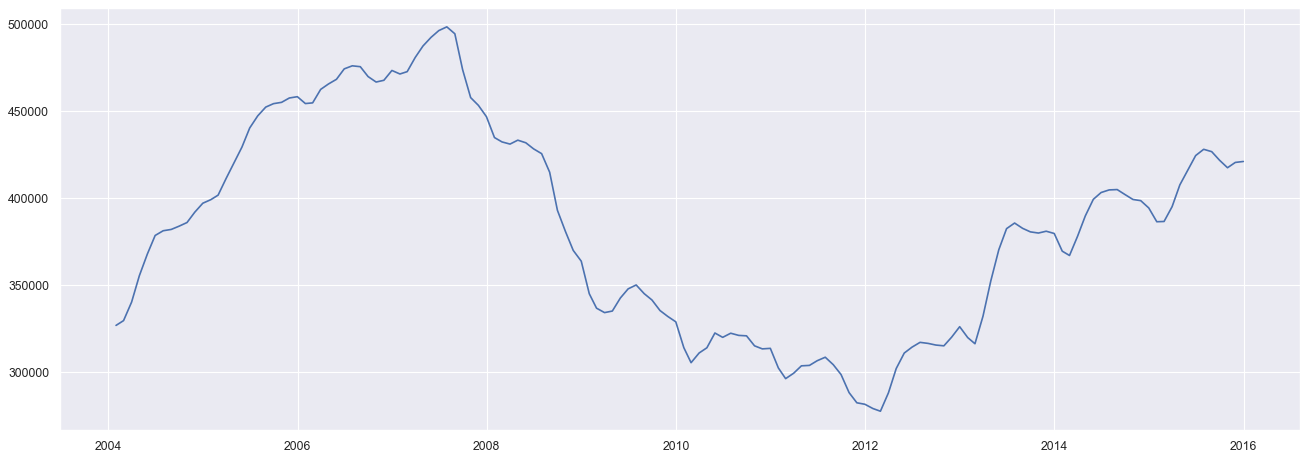

In [40]:
series_mediansoldprice_i=series_imputed.loc[(series.index <='2015-12-31') ].MedianSoldPrice

plt.figure(figsize=(20,7), dpi=80)
plt.plot(series_mediansoldprice_i)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -1.687305
p-value                          0.437665
#Lags Used                      12.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


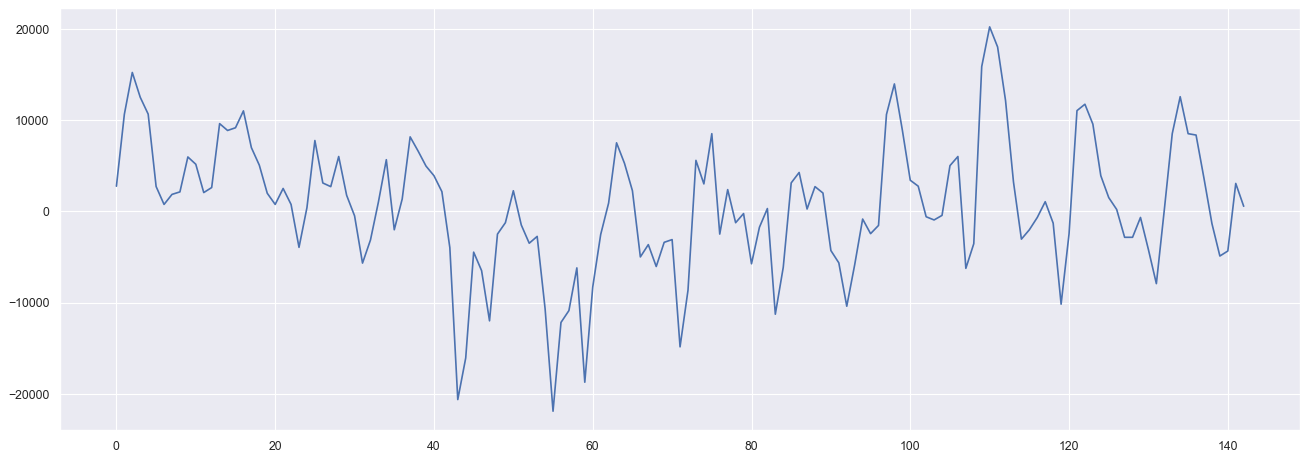

In [41]:
d1_i = list()
for i in range(1, len(series_mediansoldprice_i)):
 value = series_mediansoldprice_i[i] - series_mediansoldprice_i[i - 1]
 d1_i.append(value)

adf_test(d1_i)
plt.figure(figsize=(20,7), dpi=80)
plt.plot(d1_i) 
pyplot.show()

Results of Dickey-Fuller Test:
Test Statistic                  -4.918846
p-value                          0.000032
#Lags Used                      11.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


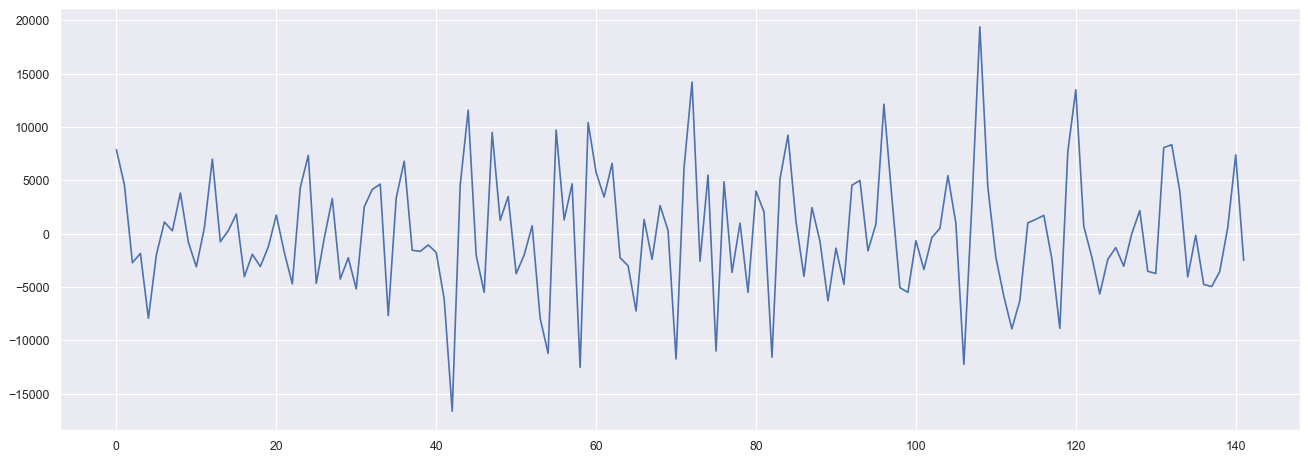

In [42]:
d2_i = list()
for i in range(1, len(d1_i)):
 value = d1_i[i] - d1_i[i - 1]
 d2_i.append(value)

adf_test(d2_i)
plt.figure(figsize=(20,7), dpi=80)
plt.plot(d2_i) 
plt.show()

In [43]:
train_size_i = int(len(series_mediansoldprice_i) * 0.80)
train_i, test_i = series_mediansoldprice_i[:train_size_i], series_mediansoldprice_i[train_size_i:]
train_i.tail()

Date
2013-03-31    332050.0
2013-04-30    352250.0
2013-05-31    370250.0
2013-06-30    382385.0
2013-07-31    385600.0
Name: MedianSoldPrice, dtype: float64

In [44]:
model_i = pm.auto_arima(train_i, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12,              # frequency of series
                      d=2,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model_i.summary())

Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 1, 1, 12); AIC=1997.658, BIC=2010.734, Fit time=0.706 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 1, 0, 12); AIC=2009.374, BIC=2014.604, Fit time=0.014 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(1, 1, 0, 12); AIC=2013.021, BIC=2023.482, Fit time=0.144 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 1, 1, 12); AIC=2013.214, BIC=2023.674, Fit time=0.201 seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(1, 1, 1, 12); AIC=1997.764, BIC=2013.455, Fit time=0.999 seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 1, 0, 12); AIC=1995.624, BIC=2006.084, Fit time=0.266 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 1, 0, 12); AIC=2011.389, BIC=2019.235, Fit time=0.034 seconds
Fit ARIMA: order=(2, 2, 1) seasonal_order=(0, 1, 0, 12); AIC=1997.604, BIC=2010.679, Fit time=0.294 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(0, 1, 0, 12); AIC=2011.192, BIC=2019.038, Fit time=0.032 seconds
Fit ARIMA: order=(1, 2, 2) s

In [45]:
series_x_i=series_imputed.loc[(series.index <='2015-12-31') ].drop('MedianSoldPrice', axis=1)
exog_train_i=series_x_i[:train_size_i]
exog_test_i=series_x_i[train_size_i:]

In [46]:
modelx_i = SARIMAX(train_i, order=(1,2,1), seasonal_order=(0,1,0,12),exog=exog_train_i)
fitx_i=modelx_i.fit()
print(fitx_i.summary())

/Users/jingwenyu/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                    MedianSoldPrice   No. Observations:                  115
Model:             SARIMAX(1, 2, 1)x(0, 1, 0, 12)   Log Likelihood                -994.456
Date:                            Mon, 09 Dec 2019   AIC                           2000.911
Time:                                    22:06:57   BIC                           2016.602
Sample:                                01-31-2004   HQIC                          2007.263
                                     - 07-31-2013                                         
Covariance Type:                              opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
MedianMortageRate  3215.1341   1547.469      2.078      0.038     182.151    6248.117
UnemploymentRa

In [47]:
fc_i = fitx_i.predict(start=115, end=143, exog=exog_test_i)

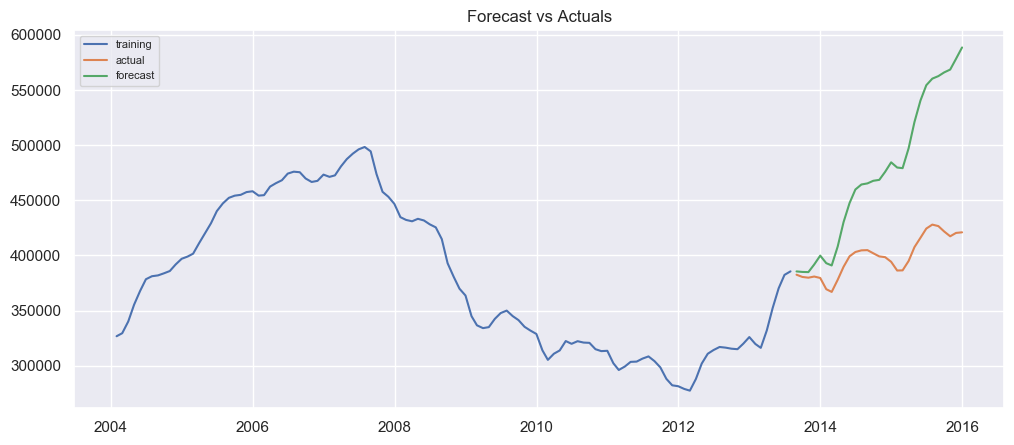

In [48]:
fc_series_i = pd.Series(fc_i)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_i, label='training')
plt.plot(test_i, label='actual')
plt.plot(fc_series_i, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [49]:
rmse = sqrt(mean_squared_error(test_i.values, fc_series_i.values))
rmse

92123.83477574767

## 2.4 Modelling with VAR

In [50]:
# select proper data range
var_series = series.loc[(series.index >= "2010-01-01") & (series.index <= "2016-01-01")]
cols = var_series.columns

In [51]:
# split train and validation
train = var_series[:int(0.8*(len(var_series)))]
valid = var_series[int(0.8*(len(var_series))):]

In [52]:
# fit my training data
from statsmodels.tsa.vector_ar.var_model import VAR

modelvar = VAR(endog=train)
modelvar_fit = modelvar.fit()

/Users/jingwenyu/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


/Users/jingwenyu/anaconda3/lib/python3.7/site-packages/statsmodels/base/wrapper.py:35: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


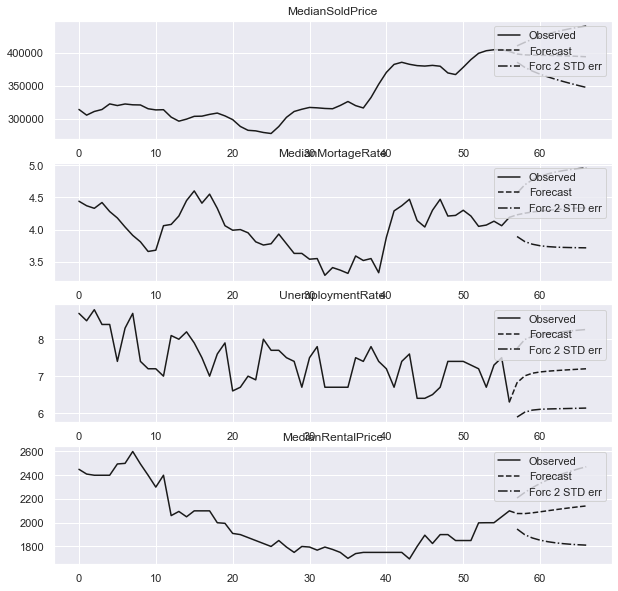

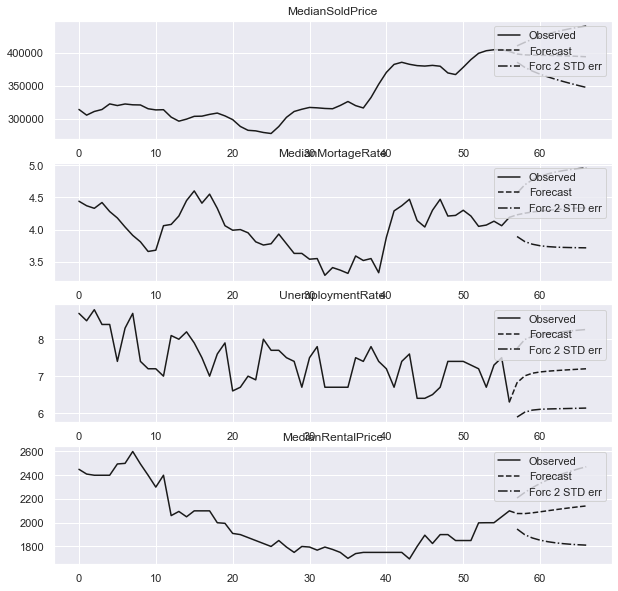

In [53]:
# make prediction on validation
prediction = modelvar_fit.forecast(modelvar_fit.y, steps=len(valid))

modelvar_fit.plot_forecast(10)

In [54]:
# calculate RMSE
var_rmse = np.sqrt(np.mean(np.square(valid - prediction)))
print(var_rmse)

MedianSoldPrice      21908.522340
MedianMortageRate        0.462443
UnemploymentRate         1.770289
MedianRentalPrice       99.923901
dtype: float64


In [56]:
print(modelvar_fit.test_causality('MedianSoldPrice', ['MedianMortageRate', 'UnemploymentRate', 'MedianRentalPrice'], kind='f'))

<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: %s do not Granger-cause MedianSoldPrice: reject at 5% significance level. Test statistic: 5.049, critical value: 2.649>, p-value: 0.002>


In [57]:
# RMSE for VAR was pretty bad, better than SARIMAX, but not as good as SARIMA

## 3. Choosing Final Model and Forecasting

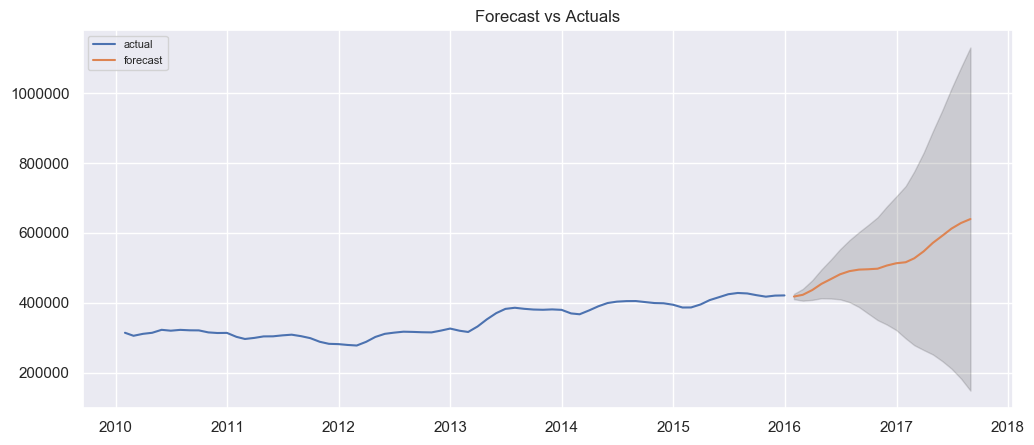

In [58]:
fitted_final = model.fit(series_mediansoldprice)
fc, conf = fitted_final.predict(20,return_conf_int=True,alpha=0.05)
fc_index = pd.date_range(start='2016-01-31', end='2017-08-31', freq='M')
fc_series = pd.Series(fc, index=fc_index)
lower_series = pd.Series(conf[:, 0], index=fc_index)
upper_series = pd.Series(conf[:, 1], index=fc_index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(series_mediansoldprice, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## 4. Export As CSV

In [59]:
fc_series_df = fc_series.to_frame("prediction")

In [60]:
fc_series_df.to_csv('prediction.csv', index=False)

In [61]:
prediction = pd.read_csv('prediction.csv',squeeze=True)

In [62]:
type(prediction)

pandas.core.series.Series

In [63]:
prediction

0     417780.297606
1     422740.859180
2     436366.502265
3     454057.459279
4     467893.824243
5     481518.726913
6     490597.276245
7     494971.826294
8     495948.259596
9     497585.082659
10    506572.973929
11    513155.368406
12    516092.904630
13    527334.686133
14    547366.251388
15    571587.230446
16    592078.220630
17    612481.931168
18    628463.822384
19    639865.954749
Name: prediction, dtype: float64